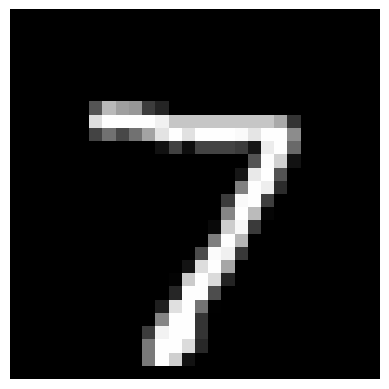

In [1]:
import pandas as pd
from PIL import Image, ImageOps
import numpy as np
import os
import random
import matplotlib.pyplot as plt


csv_file = r"C:\Users\Aaditya\Desktop\ipcv_pracs\data\mnist_test.csv"  # Replace with the provided file name
data = pd.read_csv(csv_file)

labels = data.iloc[:, 0]  # First column: Labels
pixels = data.iloc[:, 1:]  # Remaining columns: Pixel data

# Directory to save images
output_dir = r"C:\Users\Aaditya\Desktop\ipcv_pracs\mnist_images"
os.makedirs(output_dir, exist_ok=True)

for idx, (label, pixel_values) in enumerate(zip(labels, pixels.values)):
    image_array = pixel_values.reshape(28, 28).astype(np.uint8)
    img = Image.fromarray(image_array)
    img.save(f"{output_dir}/{label}_{idx}.png")
    if idx >= 10: 
        break


image_files = [f for f in os.listdir(output_dir) if f.endswith(".png")]
random_image_file = random.choice(image_files)
random_image_path = os.path.join(output_dir, random_image_file)
random_img = Image.open(random_image_path)


plt.imshow(random_img, cmap="gray")
plt.axis('off')  
plt.show()




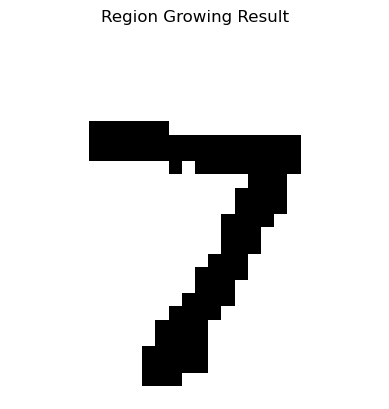

Splitting region: (0, 0, 28, 28), Mean Intensity: 23.538265306122447


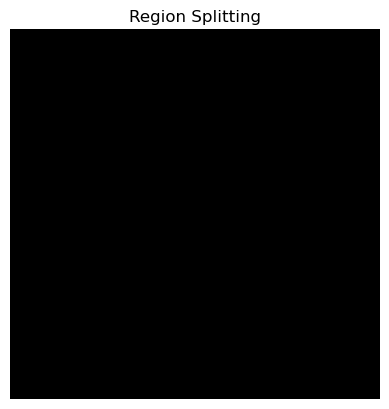

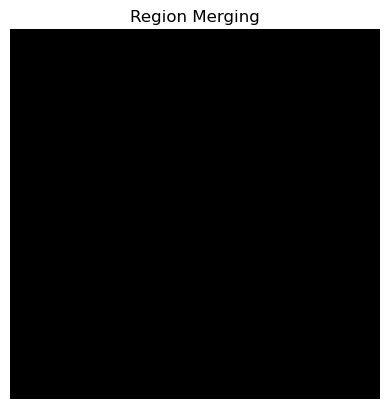

In [2]:
# Convert the selected random image to a numpy array for processing
image_array = np.array(random_img)

# Step 3: Implement Region Growing
def region_growing(image, seed, threshold):
    """
    Perform region growing from a seed pixel based on intensity threshold.
    """
    # Initialize a binary mask with all zeros
    mask = np.zeros_like(image, dtype=np.uint8)

    # Get image dimensions
    rows, cols = image.shape

    # List of pixels to be processed, starting with the seed
    pixel_list = [seed]

    # Get the intensity of the seed pixel
    seed_intensity = image[seed[0], seed[1]]

    # Directions for 4-connectivity (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while pixel_list:
        x, y = pixel_list.pop()

        # Mark the current pixel as part of the region
        mask[x, y] = 255

        # Explore neighboring pixels
        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Check if within bounds and if the pixel has not been visited yet
            if 0 <= nx < rows and 0 <= ny < cols and mask[nx, ny] == 0:
                # If the intensity difference is less than the threshold, add to the region
                if abs(image[nx, ny] - seed_intensity) < threshold:
                    pixel_list.append((nx, ny))

    return mask

# Choose a random seed pixel for region growing
seed_pixel = (random.randint(0, image_array.shape[0] - 1), random.randint(0, image_array.shape[1] - 1))
threshold = 20  # Define a threshold value for region growing

# Perform region growing
region_mask = region_growing(image_array, seed_pixel, threshold)

# Display the result of region growing
plt.imshow(region_mask, cmap="gray")
plt.title("Region Growing Result")
plt.axis('off')
plt.show()

# Step 4: Region Splitting with debugging
def region_splitting(image, threshold):
    """
    Performs region splitting based on intensity difference.
    """
    rows, cols = image.shape
    regions = [(0, 0, rows, cols)]  # Start with the whole image as a region
    split_regions = []

    while regions:
        r1, c1, r2, c2 = regions.pop()
        region = image[r1:r2, c1:c2]
        region_mean = np.mean(region)

        print(f"Splitting region: ({r1}, {c1}, {r2}, {c2}), Mean Intensity: {region_mean}")

        # If the region's intensity difference is larger than the threshold, split it
        if np.all(abs(region - region_mean) > threshold):
            # Split the region into 4 quadrants
            mid_row = (r1 + r2) // 2
            mid_col = (c1 + c2) // 2
            regions.append((r1, c1, mid_row, mid_col))
            regions.append((r1, mid_col, mid_row, c2))
            regions.append((mid_row, c1, r2, mid_col))
            regions.append((mid_row, mid_col, r2, c2))
        else:
            split_regions.append((r1, c1, r2, c2))  # Keep the current region if it's homogeneous

    return split_regions

# Step 5: Region Merging with debugging
def region_merging(image, regions, threshold):
    """
    Merges regions based on similarity of their mean intensities.
    """
    merged_image = np.zeros_like(image)

    for r1, c1, r2, c2 in regions:
        region = image[r1:r2, c1:c2]
        region_mean = np.mean(region)

        for other_r1, other_c1, other_r2, other_c2 in regions:
            if (r1 != other_r1 or c1 != other_c1 or r2 != other_r2 or c2 != other_c2):
                other_region = image[other_r1:other_r2, other_c1:other_c2]
                other_mean = np.mean(other_region)

                print(f"Comparing regions: ({r1}, {c1}, {r2}, {c2}) vs ({other_r1}, {other_c1}, {other_r2}, {other_c2}), "
                      f"Mean Intensities: {region_mean} vs {other_mean}")

                # Merge regions if their intensity difference is below the threshold
                if abs(region_mean - other_mean) < threshold:
                    merged_image[r1:r2, c1:c2] = 255
                    merged_image[other_r1:other_r2, other_c1:other_c2] = 255
    return merged_image

# Perform region splitting
split_regions = region_splitting(image_array, threshold)

# Display the split regions
split_image = np.zeros_like(image_array)

for r1, c1, r2, c2 in split_regions:
    split_image[r1:r2, c1:c2] = 255  # Mark regions in white

plt.imshow(split_image, cmap="gray")
plt.title("Region Splitting")
plt.axis('off')
plt.show()

# Perform region merging
merged_image = region_merging(image_array, split_regions, threshold)

# Display the merged regions
plt.imshow(merged_image, cmap="gray")
plt.title("Region Merging")
plt.axis('off')
plt.show()
